## Metric #2: Flow statistics on Sobel-filtered images

Sobel filter can highlight high-frequency variations on an image. Thus, we can apply sobel filter on the feature tracking results and calculate statistics of the on-ice pixels, which could serve as a metric to evaluate detail richness.

### Requirements and Limits

- Have to prepare polygon(s) to select on-ice pixels. 

### Procedure

1. Prepare the feature tracking results as Geotiff files, ideally $V_x$ as one file and $V_y$ as the other. The unit for pixel value is flexible, from pixels, pixels/day, pixels/year, to meters, meters/day, to meters/year. **In this notebook, all of the feature tracking data use meters/day as the unit of the pixel value.**

2. Locate on-ice area and make an ESRI shapefile (polygon format) for that. Future development includes the RGI glacier outline as the on-ice area as well.

3. Use `gftt.sobel_scattering` and `gftt.plot_off_ice_errors` to calculate, analyze, and visualize the flow statistics.

### Analysis

#### 1. Basic information, importing modules

- Test area: **Kaskawulsh Glacier**
- Test packages: **CARST, Vmap, GIV, autoRIFT**
- Test pair: **Landsat 8 20180304-20180405**

In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [2]:
import gftt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors, cm
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd
# import seaborn as sns

#### 2. Load the feature tracking data list and on-ice area shapefile

Each row is a feature tracking test using a specific parameter combination described in each field.

In [3]:
df = pd.read_csv('../results_agu21.csv', dtype=str)
df

Date Chip (px) Resolution (px) Prefilter  \
0   LS8-20180304-20180405        32               1       Gau   
1   LS8-20180304-20180405        32               1      NAOF   
2   LS8-20180304-20180405        32               1      None   
3   LS8-20180304-20180405        32               4       Gau   
4   LS8-20180304-20180405        32               4      NAOF   
5   LS8-20180304-20180405        32               4      None   
6   LS8-20180304-20180405        32               8       Gau   
7   LS8-20180304-20180405        32               8      NAOF   
8   LS8-20180304-20180405        32               8      None   
9   LS8-20180304-20180405        64               1       Gau   
10  LS8-20180304-20180405        64               1      NAOF   
11  LS8-20180304-20180405        64               1      None   
12  LS8-20180304-20180405        64               4       Gau   
13  LS8-20180304-20180405        64               4      NAOF   
14  LS8-20180304-20180405        64               4      None   
15  LS8-20180304-20180405        64               8       Gau   
16  LS8-20180304-20180405        64               8      NAOF   
17  LS8-20180304-20180405        64               8      None   
18  LS8-20180304-20180405     multi              16      NAOF   
19  LS8-20180304-20180405     multi               4      NAOF   
20  LS8-20180304-20180405     multi              16       Gau   
21  LS8-20180304-20180405     multi               4       Gau   
22  LS8-20180304-20180405     multi              16      None   
23  LS8-20180304-20180405     multi               4      None   
24  LS8-20180304-20180405        31               1       Gau   
25  LS8-20180304-20180405        65               1       Gau   
26  LS8-20180304-20180405        31               1      None   
27  LS8-20180304-20180405        65               1      None   
28  LS8-20180304-20180405        31               1       LoG   
29  LS8-20180304-20180405        31               1       LoG   
30  LS8-20180304-20180405        32               4      None   
31  LS8-20180304-20180405        32               8      None   
32  LS8-20180304-20180405        64               4      None   
33  LS8-20180304-20180405        64               8      None   
34  LS8-20180304-20180405        32               4       Gau   
35  LS8-20180304-20180405        32               8       Gau   
36  LS8-20180304-20180405        64               4       Gau   
37  LS8-20180304-20180405        64               8       Gau   
38  LS8-20180304-20180405        32               4      NAOF   
39  LS8-20180304-20180405        32               8      NAOF   
40  LS8-20180304-20180405        64               4      NAOF   
41  LS8-20180304-20180405        64               8      NAOF   

                 Subpixel  Software  \
0    16-node oversampling     CARST   
1    16-node oversampling     CARST   
2    16-node oversampling     CARST   
3    16-node oversampling     CARST   
4    16-node oversampling     CARST   
5    16-node oversampling     CARST   
6    16-node oversampling     CARST   
7    16-node oversampling     CARST   
8    16-node oversampling     CARST   
9    16-node oversampling     CARST   
10   16-node oversampling     CARST   
11   16-node oversampling     CARST   
12   16-node oversampling     CARST   
13   16-node oversampling     CARST   
14   16-node oversampling     CARST   
15   16-node oversampling     CARST   
16   16-node oversampling     CARST   
17   16-node oversampling     CARST   
18  interest point groups       GIV   
19  interest point groups       GIV   
20  interest point groups       GIV   
21  interest point groups       GIV   
22  interest point groups       GIV   
23  interest point groups       GIV   
24              parabolic      Vmap   
25              parabolic      Vmap   
26              parabolic      Vmap   
27              parabolic      Vmap   
28              parabolic      Vmap   
29        affine adaptive      Vmap   
30              

Load the off-ice area shapefile.

In [4]:
# on-ice area
in_shp = '/home/jovyan/Projects/PX_comparison/Bedrock_shp/glacier_V1_Kaskawulsh_s.shp'
on_ice = gpd.read_file(in_shp)

#### 3. Demo for a single test 

In [5]:
## Example results
demo = df.loc[22]
print(demo)

Date                                           LS8-20180304-20180405
Chip (px)                                                      multi
Resolution (px)                                                   16
Prefilter                                                       None
Subpixel                                       interest point groups
Software                                                         GIV
Vx                 /home/jovyan/Projects/PX_comparison/PX/GIV/u_l...
Vy                 /home/jovyan/Projects/PX_comparison/PX/GIV/v_l...
OIE-x                                             0.6140104136459059
OIE-y                                             0.7672143993258354
SS-x                                              4.8425141531327425
SS-y                                               6.934244151078591
Name: 22, dtype: object


Now make a special `viridis` colormap designed for Kaskawulsh:

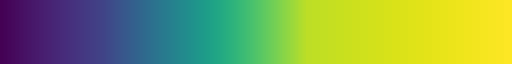

In [7]:
viridis = cm.get_cmap('viridis', 256)
newcolors1 = viridis(np.linspace(0, 0.2, 128))
newcolors2 = viridis(np.linspace(0.2, 0.9, 256))
newcolors3 = viridis(np.linspace(0.9, 1, 256))
newcolors = np.vstack((newcolors1, newcolors2, newcolors3))
cmap = ListedColormap(newcolors)
cmap.set_over(np.array([202,0,32,128]) / 255)
cmap.set_under(np.array([0,0,0,128]) / 255)
cmap

The velocity x component looks like this:

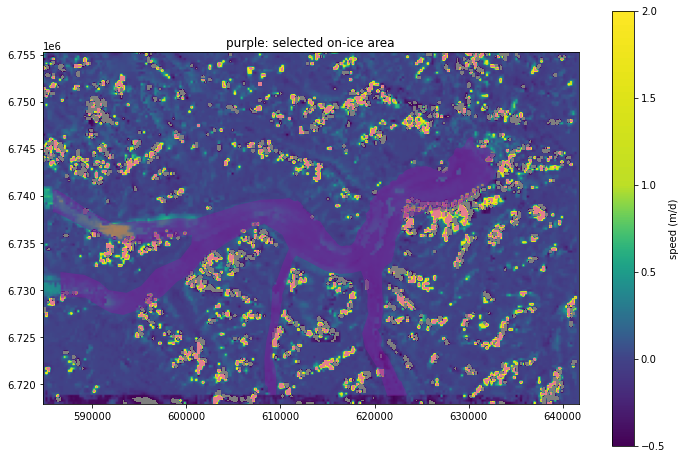

In [9]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8))

with rasterio.open(demo.Vx) as v_src:
    v = v_src.read(1)
    show(v_src, ax=ax0, vmin=-0.5, vmax=2, cmap=cmap)
    
cbar =  fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-0.5, vmax=2), cmap=cmap), ax=ax0)
cbar.set_label('speed (m/d)')
on_ice.plot(ax=ax0, alpha=0.5, facecolor='xkcd:purple')
ax0.set_title('purple: selected on-ice area');

Now we can call the `sobel_scattering` function from GFTT and calculate flow statistics:

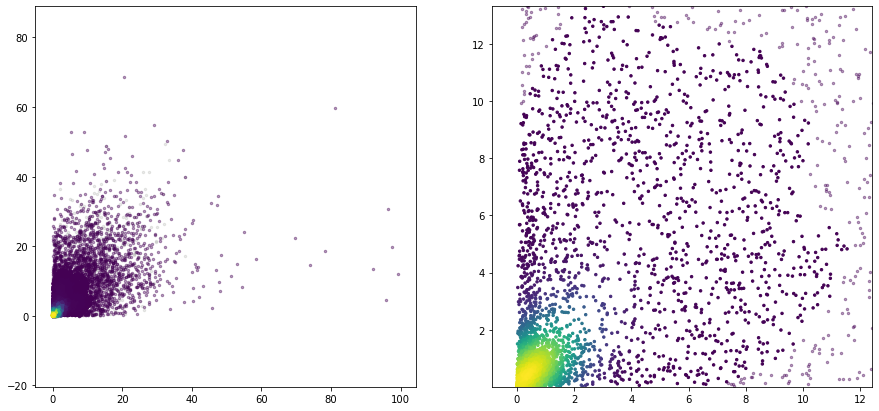

In [10]:
fig, ax1 = plt.subplots(1, 2, figsize=(15, 7))

for ax in ax1:
    ax.axis('equal')
sx, sy, z, thres_idx = gftt.sobel_scattering(vxfile=demo.Vx, vyfile=demo.Vy, on_ice_area=in_shp, ax=ax1[0])
gftt.plot_off_ice_errors(sx, sy, z, thres_idx, ax=ax1[1])

# limrange = (0, 3)
# ax1[0].set_xlim(limrange)
# ax1[0].set_ylim(limrange)
# ax1[1].set_xlim(limrange)
# ax1[1].set_ylim(limrange)

Here, x-axis is the (Sobel-flavored) gradient of flow speed along the x direction (m/day, per pixel), y-axis is the (Sobel-flavored) gradient of flow speed along the y direction (m/day, per pixel). Again, we randomly select 10,000 pixels and color code them based on the Gaussian kernel density estimate, and the other pixels are plotting as gray points. Transparent color points have a kernel density below a chosen confidence level, which is 3.0 by default and corresponds to a confidence level of 99.7%. 

#### 4. Off-ice error for 42 tests using the same Landsat 8 pair

Here's what the data ($V_x$ of all 42 tests) look like:

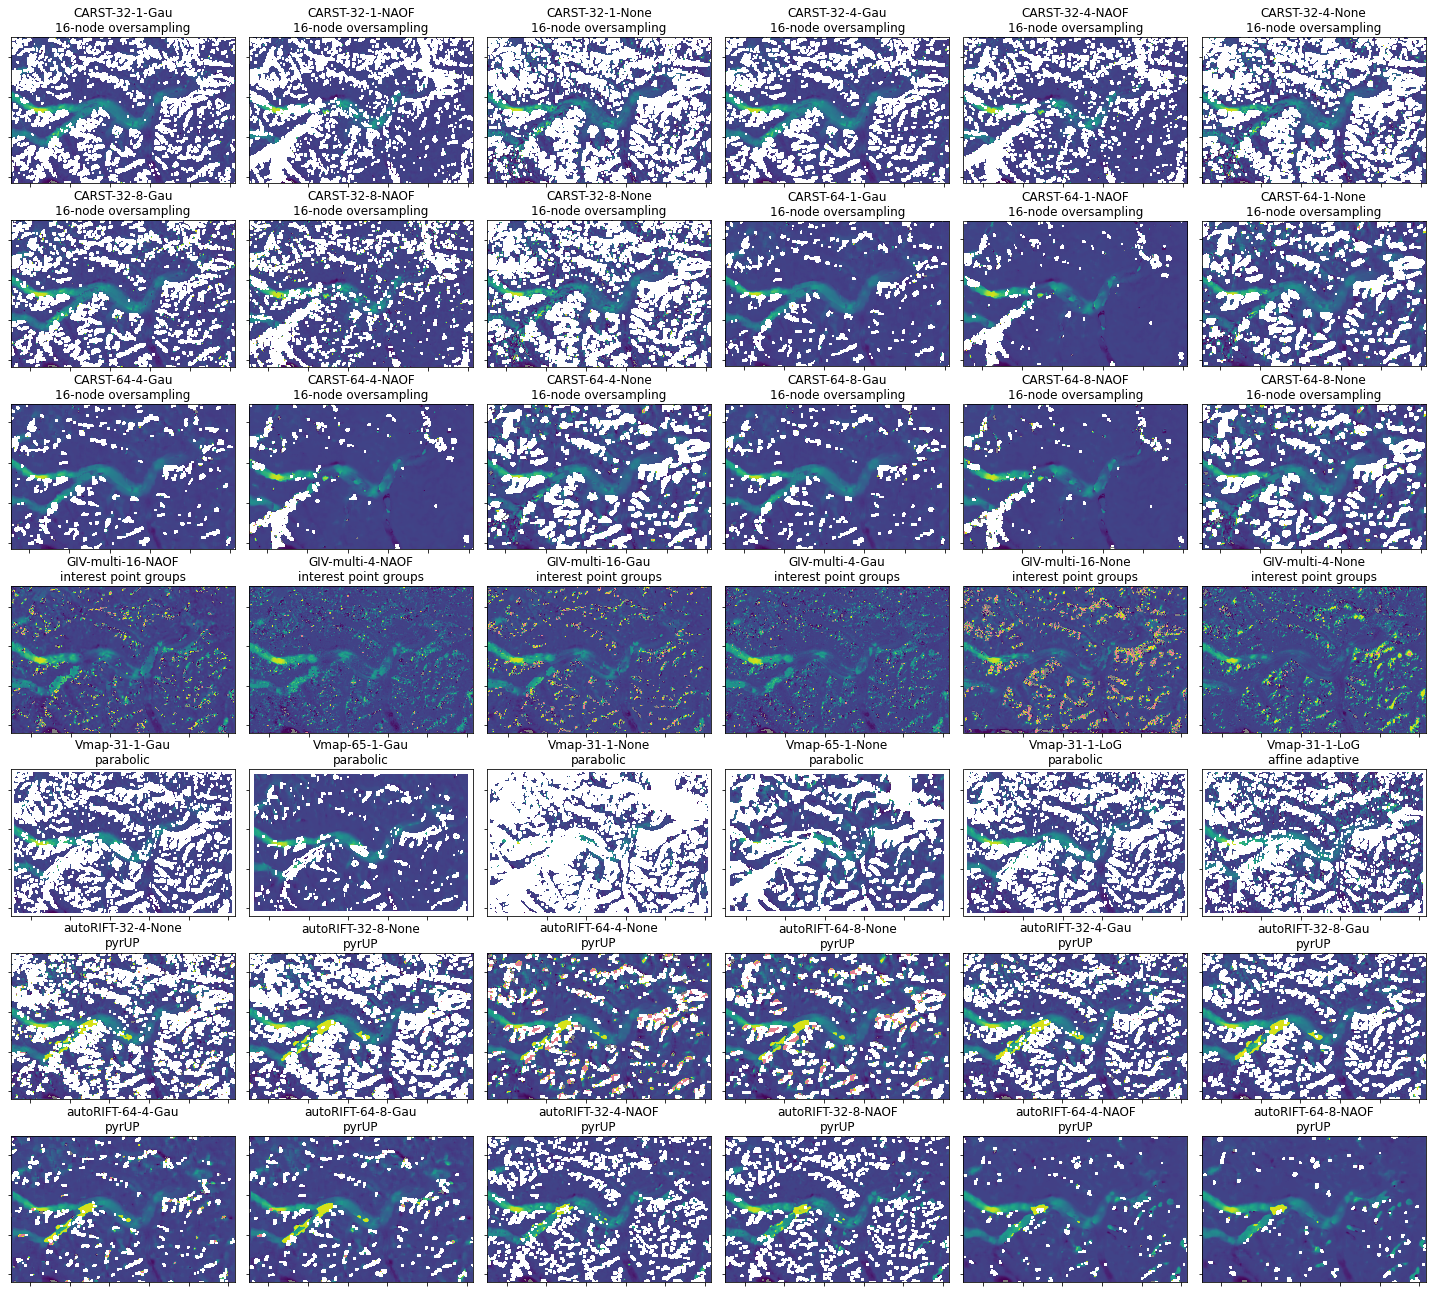

In [11]:
fig, ax2 = plt.subplots(7, 6, figsize=(20, 18))

demo = df
n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax2[n // 6, n % 6]
    
    with rasterio.open(row.Vx) as vx_src:
        show(vx_src, ax=ax_sel, vmin=-0.5, vmax=2, cmap=cmap)
    ax_sel.set_title(label)
    ax_sel.xaxis.set_ticklabels([])
    ax_sel.yaxis.set_ticklabels([])
        
    n += 1
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
# fig.savefig('tmp.png')

flow speed gradient plots for all 42 tests:

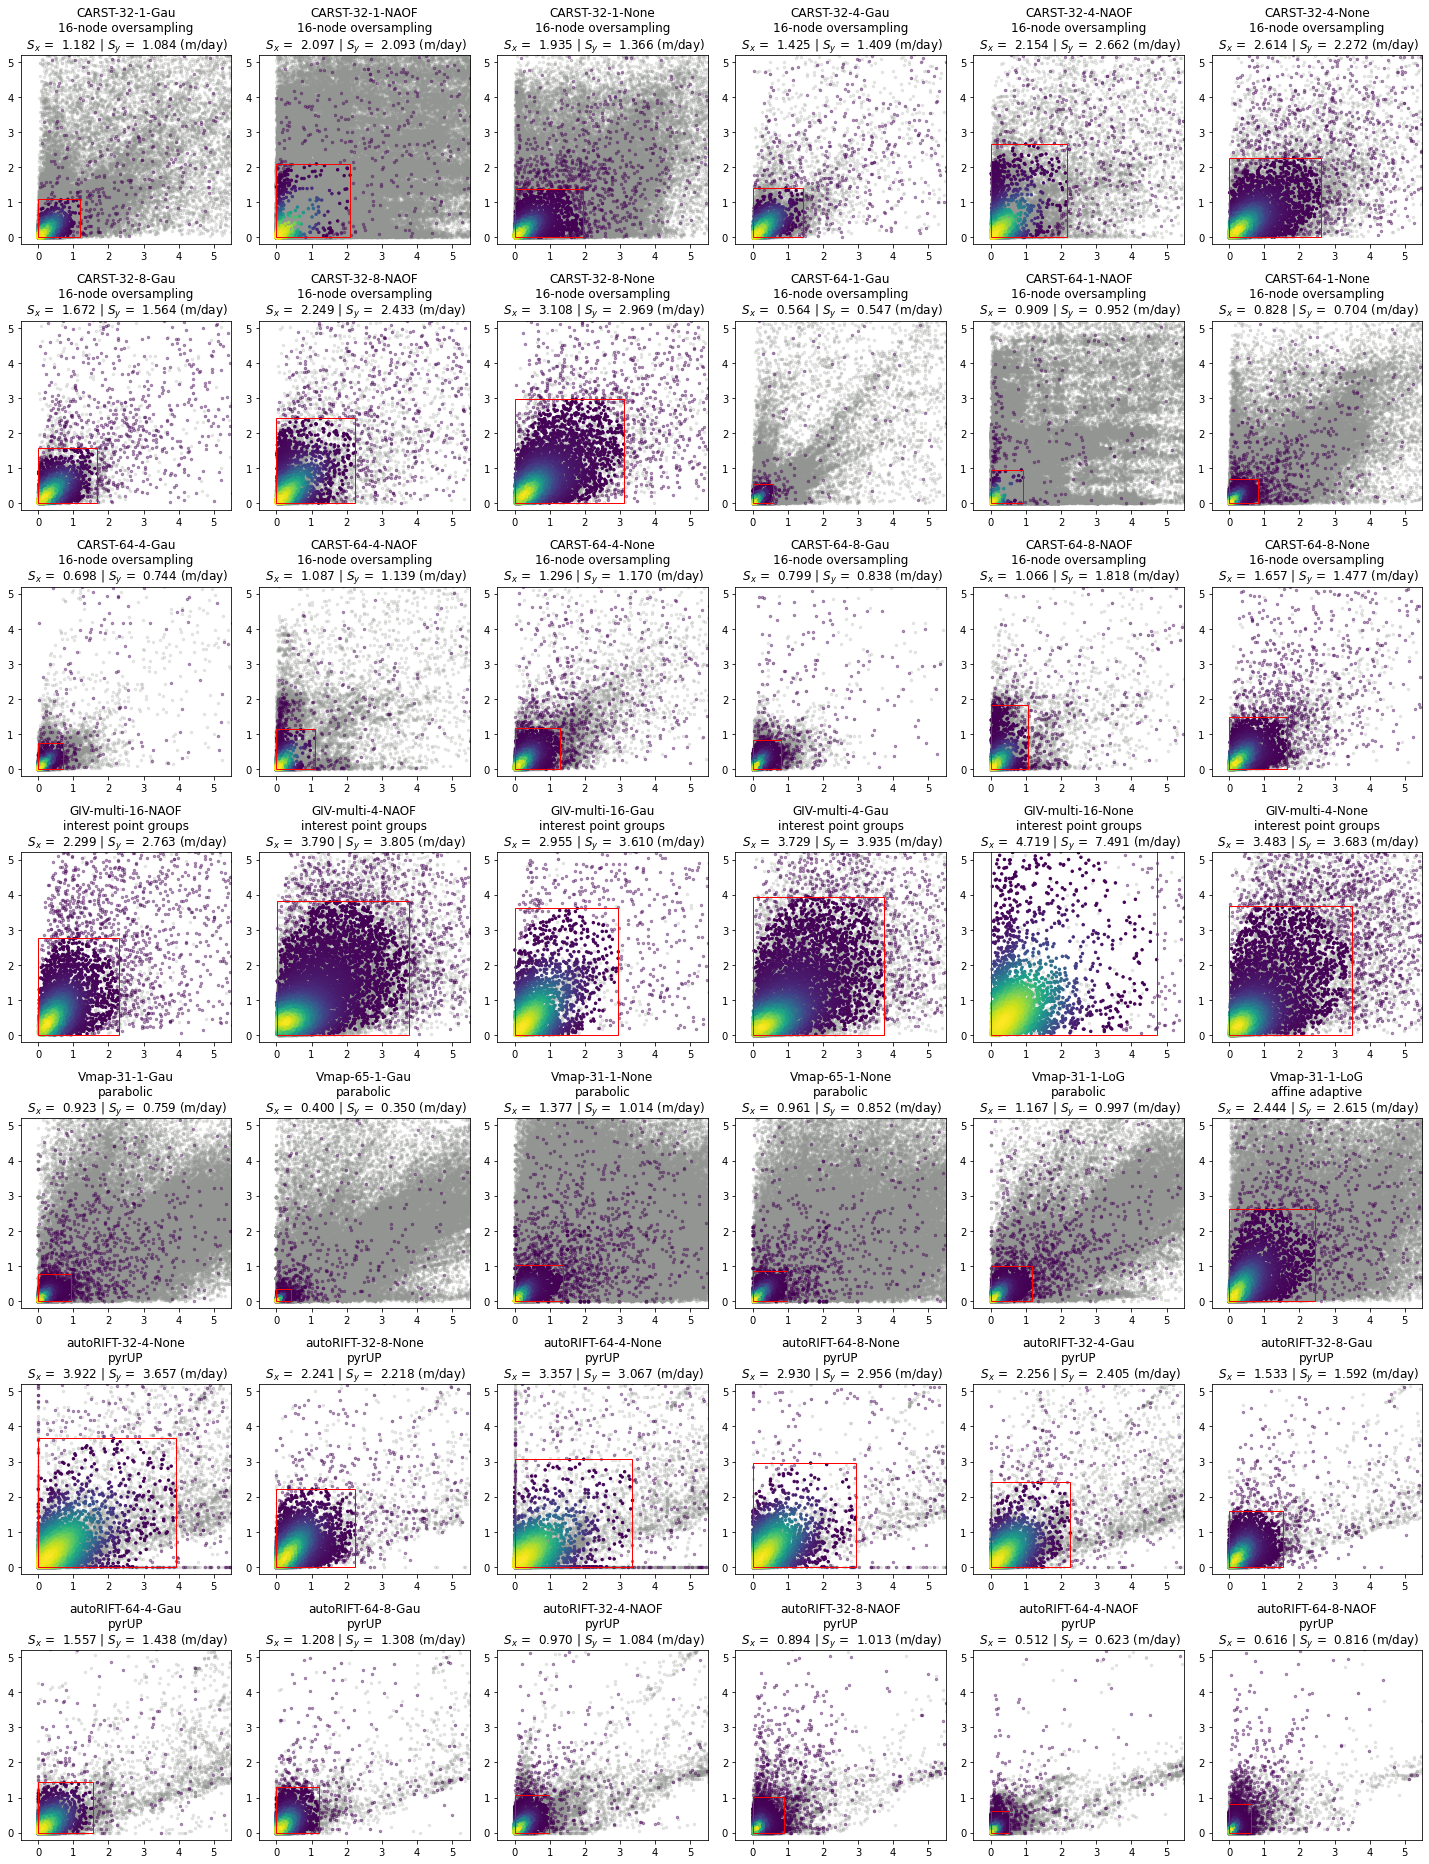

In [12]:
fig, ax3 = plt.subplots(7, 6, figsize=(20, 26))

demo = df
n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax3[n // 6, n % 6]
    ax_sel.axis('equal')
    
    if row.Software == 'GIV':
        sx, sy, z, thres_idx = gftt.sobel_scattering(vxfile=row.Vx, vyfile=row.Vy, wfile=row.Vx.replace('u_', 'pkr_'), on_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    else:
        sx, sy, z, thres_idx = gftt.sobel_scattering(vxfile=row.Vx, vyfile=row.Vy, on_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    # gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax_sel, zoom=True)
    ax_sel.set_xlim(0, 5)
    ax_sel.set_ylim(0, 5)

    rect = patches.Rectangle((min(sx[thres_idx]), min(sy[thres_idx])), max(sx[thres_idx]) - min(sx[thres_idx]), max(sy[thres_idx]) - min(sy[thres_idx]), 
                              linewidth=1, edgecolor='r', facecolor='none')
    ax_sel.add_patch(rect)
    
    demo.loc[idx, 'SS-x'] = max(sx[thres_idx])
    demo.loc[idx, 'SS-y'] = max(sy[thres_idx])
    label += '\n $S_x$ = {:6.3f} | $S_y$ = {:6.3f} (m/day)'.format(demo.loc[idx, 'SS-x'], 
                                                                   demo.loc[idx, 'SS-y'])
    ax_sel.set_title(label)
    # ax_sel.xaxis.set_ticklabels([])
    # ax_sel.yaxis.set_ticklabels([])
    

        
    n += 1
    
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
# fig.savefig('tmp.png')

Results are attached to the right of the metadata sheet. (`SS-x` and `SS-y`)

In [13]:
# demo.to_csv('../results_agu21.csv', index=False)
demo

Date Chip (px) Resolution (px) Prefilter  \
0   LS8-20180304-20180405        32               1       Gau   
1   LS8-20180304-20180405        32               1      NAOF   
2   LS8-20180304-20180405        32               1      None   
3   LS8-20180304-20180405        32               4       Gau   
4   LS8-20180304-20180405        32               4      NAOF   
5   LS8-20180304-20180405        32               4      None   
6   LS8-20180304-20180405        32               8       Gau   
7   LS8-20180304-20180405        32               8      NAOF   
8   LS8-20180304-20180405        32               8      None   
9   LS8-20180304-20180405        64               1       Gau   
10  LS8-20180304-20180405        64               1      NAOF   
11  LS8-20180304-20180405        64               1      None   
12  LS8-20180304-20180405        64               4       Gau   
13  LS8-20180304-20180405        64               4      NAOF   
14  LS8-20180304-20180405        64               4      None   
15  LS8-20180304-20180405        64               8       Gau   
16  LS8-20180304-20180405        64               8      NAOF   
17  LS8-20180304-20180405        64               8      None   
18  LS8-20180304-20180405     multi              16      NAOF   
19  LS8-20180304-20180405     multi               4      NAOF   
20  LS8-20180304-20180405     multi              16       Gau   
21  LS8-20180304-20180405     multi               4       Gau   
22  LS8-20180304-20180405     multi              16      None   
23  LS8-20180304-20180405     multi               4      None   
24  LS8-20180304-20180405        31               1       Gau   
25  LS8-20180304-20180405        65               1       Gau   
26  LS8-20180304-20180405        31               1      None   
27  LS8-20180304-20180405        65               1      None   
28  LS8-20180304-20180405        31               1       LoG   
29  LS8-20180304-20180405        31               1       LoG   
30  LS8-20180304-20180405        32               4      None   
31  LS8-20180304-20180405        32               8      None   
32  LS8-20180304-20180405        64               4      None   
33  LS8-20180304-20180405        64               8      None   
34  LS8-20180304-20180405        32               4       Gau   
35  LS8-20180304-20180405        32               8       Gau   
36  LS8-20180304-20180405        64               4       Gau   
37  LS8-20180304-20180405        64               8       Gau   
38  LS8-20180304-20180405        32               4      NAOF   
39  LS8-20180304-20180405        32               8      NAOF   
40  LS8-20180304-20180405        64               4      NAOF   
41  LS8-20180304-20180405        64               8      NAOF   

                 Subpixel  Software  \
0    16-node oversampling     CARST   
1    16-node oversampling     CARST   
2    16-node oversampling     CARST   
3    16-node oversampling     CARST   
4    16-node oversampling     CARST   
5    16-node oversampling     CARST   
6    16-node oversampling     CARST   
7    16-node oversampling     CARST   
8    16-node oversampling     CARST   
9    16-node oversampling     CARST   
10   16-node oversampling     CARST   
11   16-node oversampling     CARST   
12   16-node oversampling     CARST   
13   16-node oversampling     CARST   
14   16-node oversampling     CARST   
15   16-node oversampling     CARST   
16   16-node oversampling     CARST   
17   16-node oversampling     CARST   
18  interest point groups       GIV   
19  interest point groups       GIV   
20  interest point groups       GIV   
21  interest point groups       GIV   
22  interest point groups       GIV   
23  interest point groups       GIV   
24              parabolic      Vmap   
25              parabolic      Vmap   
26              parabolic      Vmap   
27              parabolic      Vmap   
28              parabolic      Vmap   
29        affine adaptive      Vmap   
30              

And here's another figure showing the full extent of the flow velocity gradient plot.

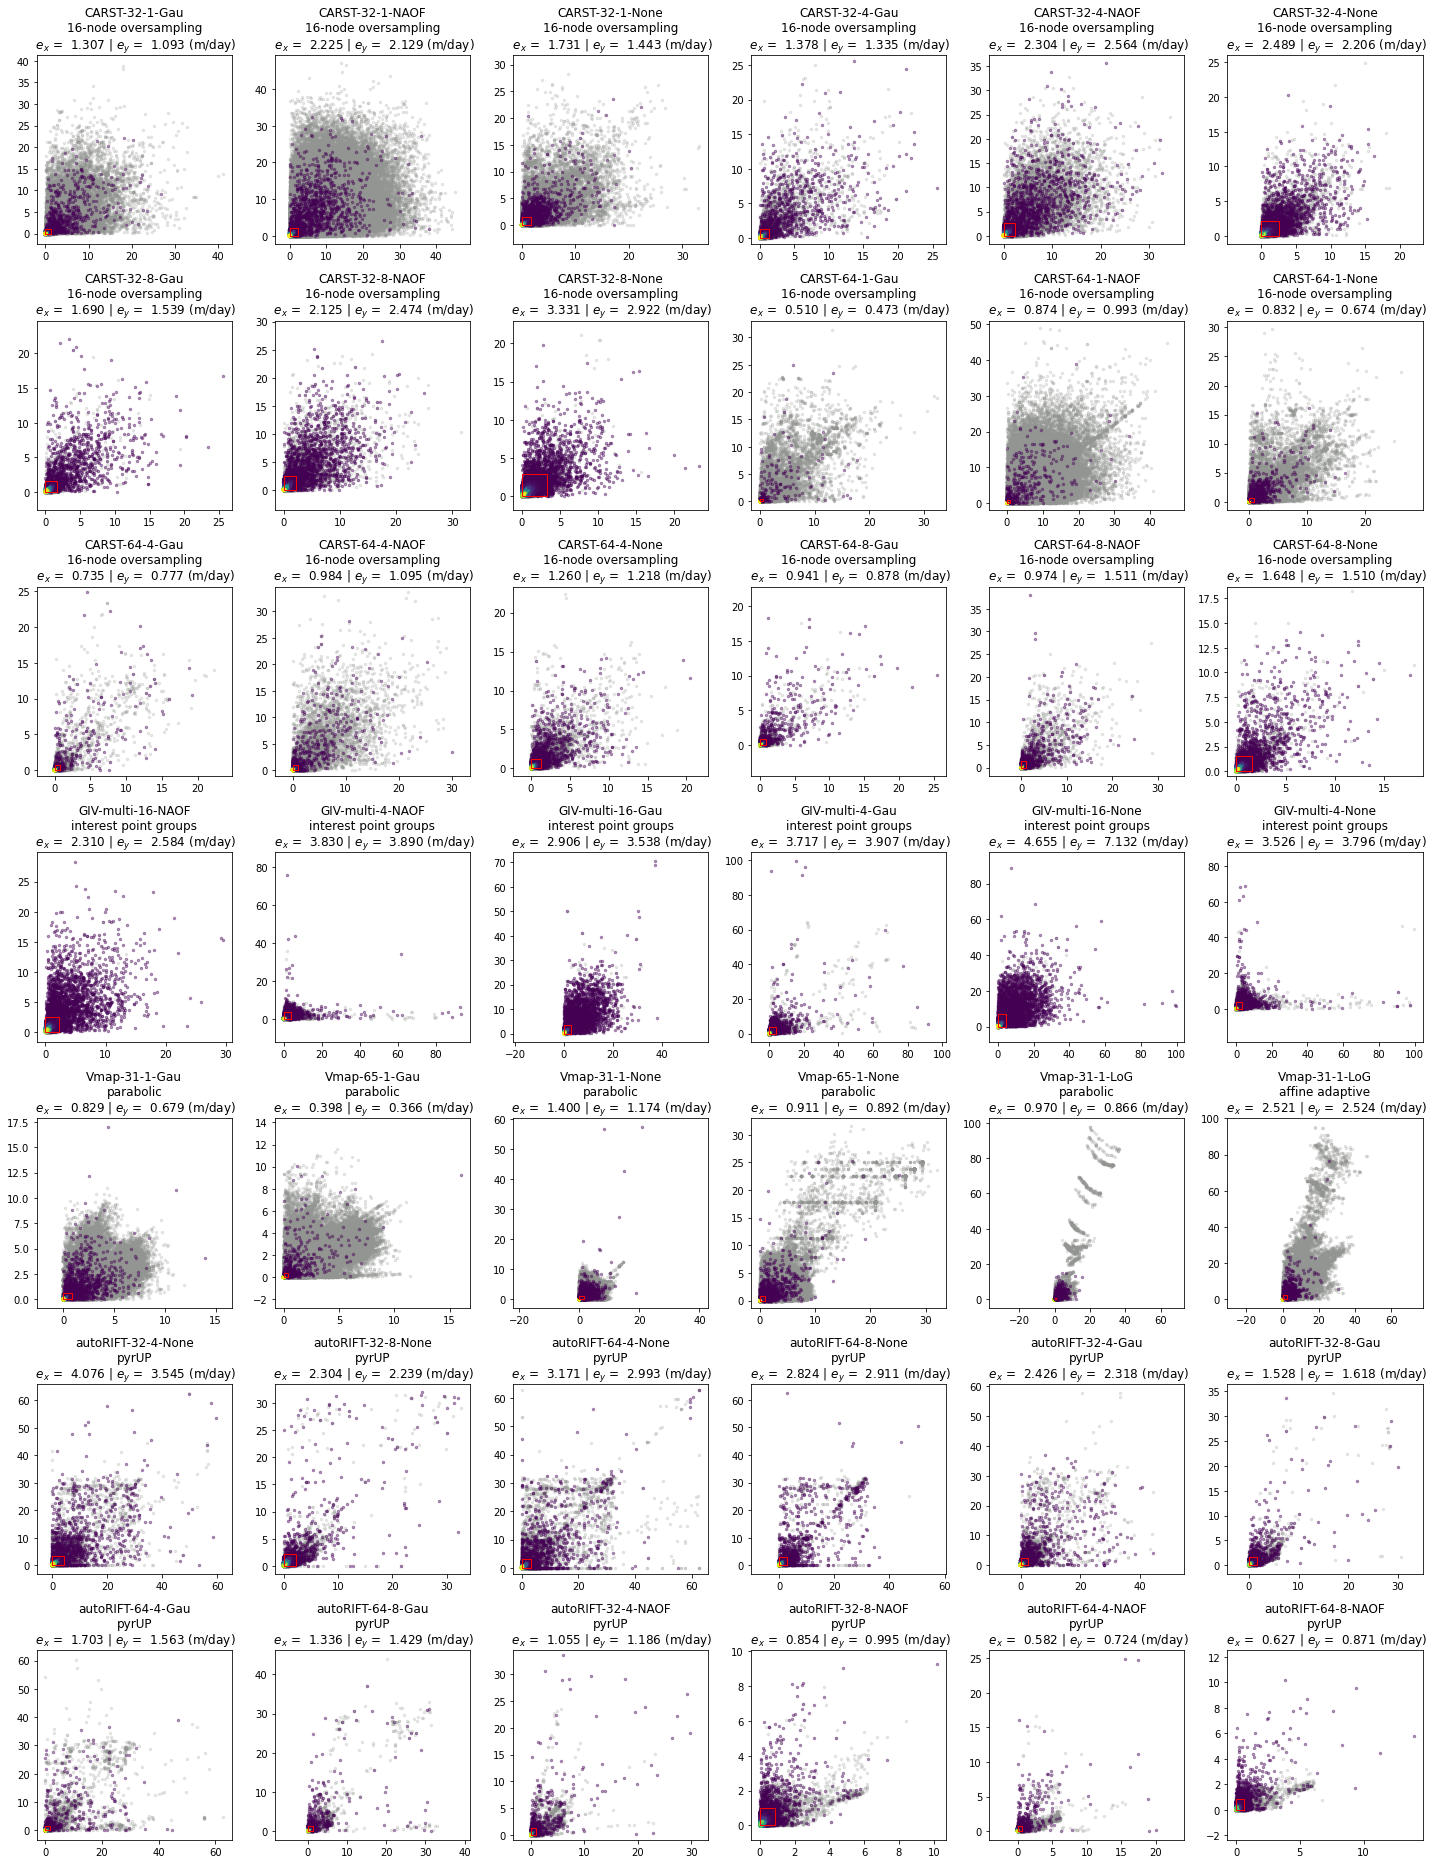

In [14]:
fig, ax4 = plt.subplots(7, 6, figsize=(20, 26))

n = 0
demo = df

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax4[n // 6, n % 6]
    ax_sel.axis('equal')

    if row.Software == 'GIV':
        sx, sy, z, thres_idx = gftt.sobel_scattering(vxfile=row.Vx, vyfile=row.Vy, wfile=row.Vx.replace('u_', 'pkr_'), on_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    else:
        sx, sy, z, thres_idx = gftt.sobel_scattering(vxfile=row.Vx, vyfile=row.Vy, on_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    # gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax_sel, zoom=True)
    # ax_sel.set_xlim(-0.5, 0.5)
    # ax_sel.set_ylim(-0.5, 0.5)
    
    rect = patches.Rectangle((min(sx[thres_idx]), min(sy[thres_idx])), max(sx[thres_idx]) - min(sx[thres_idx]), max(sy[thres_idx]) - min(sy[thres_idx]), 
                              linewidth=1, edgecolor='r', facecolor='none')
    ax_sel.add_patch(rect)
    label += '\n $e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(max(sx[thres_idx]), 
                                                                   max(sy[thres_idx]))
    ax_sel.set_title(label)
    # ax_sel.xaxis.set_ticklabels([])
    # ax_sel.yaxis.set_ticklabels([])
        
    n += 1
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')